In [1]:
# 필요한 모듈 불러오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# (1) 다시 한 번, 내 입맛대로 데이터 준비하기

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
# date 분리하기 - int형으로 변경하기
train['date'] = train['date'].apply(lambda i : i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [5]:
# target 컬럼 설정하기
y = train['price']
del train['price'] # train파일에서 price 삭제

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
# id 컬럼 삭제
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### test 데이터에도 같은 작업 진행해주기

In [7]:
# date 분리하기 - int형으로 변경하기
test['date'] = test['date'].apply(lambda i : i[:6]).astype(int)
train.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [8]:

del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

#### kdeplot을 활용하여 y의 분포값 확인하기

<AxesSubplot:xlabel='price', ylabel='Density'>

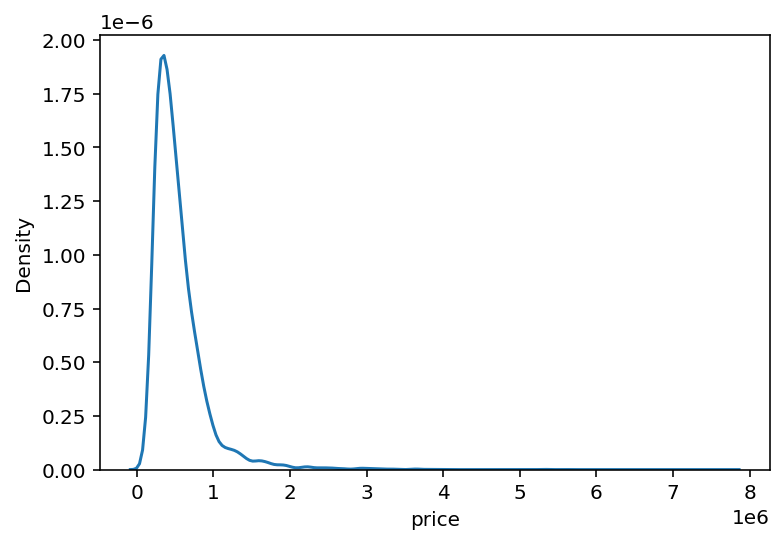

In [10]:
sns.kdeplot(y)

왼쪽으로 치우져쳐 있으므로, log변환을 통해 가우시안 분포로 만들어준다.(정규분포화)

y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다. np.expm1()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.

In [11]:
y = np.log1p(y)

In [12]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

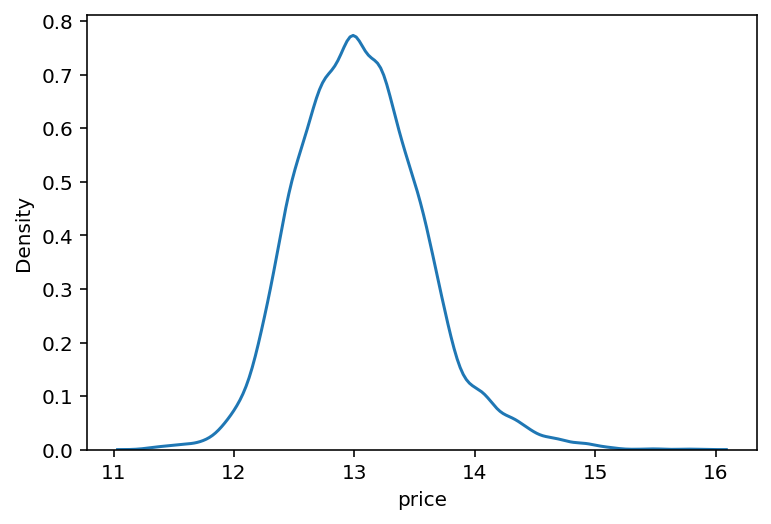

In [13]:
# log 변환한 y 출력하기
sns.kdeplot(y)

In [14]:
# train.info()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 2) 다양한 실험을 위해 함수로 만들어 쓰자

## RMSE 계산

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # RMSE 점수 계산

In [16]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


### 앙상블 위해 4개 모델 불러오기

- XGBRegressor
- LGBMRegressor
- GradientBoostingRegressor
- RandomForestRegressor

In [17]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#### 모델 인스턴스를 생성한 후 models라는 리스트에 넣기

In [18]:
gboost = GradientBoostingRegressor(random_state = 2020)
xgboost = XGBRegressor(random_state = 2020)
lightgbm = LGBMRegressor(random_state = 2020)
rdforest = RandomForestRegressor(random_state = 2020)

In [19]:
models = [gboost, xgboost, lightgbm, rdforest]

In [20]:
# model 이름 출력해보기
xgboost.__class__.__name__

'XGBRegressor'

In [21]:
# for문을 이용하여 네가지 모델에 대해 RMSE값을 빠르게 얻음

df = {}
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2020, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

In [22]:
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [23]:
# 직접 함수 만들어보기
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=2020, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)

        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)

        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [24]:
get_scores(models, train, y)

RMSE
GradientBoostingRegressor  128360.196497
RandomForestRegressor      125487.071025
LGBMRegressor              111920.367359
XGBRegressor               110318.669566

## (3) 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [25]:
from sklearn.model_selection import GridSearchCV

### 랜덤탐색이란?
랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.


### GridSearchCV란?

사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하다.
그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있다.

#### 인자

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 

In [26]:
# parm_grid에 탐색할 xboost관련 하이퍼 파라미터 넣어 준비
param_grid = {'n_estimators' : [50, 100], 'max_depth' : [1, 10]}

In [27]:
# 모델 준비 
model = LGBMRegressor(ramdom_state = 2020)

GridSearchCV를 이용하여 grid_model을 초기화하고, , train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [30]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Unknown parameter: ramdom_state
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(ramdom_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [31]:
# 실험에 대한 결과는 grid_model.cv_results_에 저장된다.
grid_model.cv_results_

{'mean_fit_time': array([0.0724369 , 0.06855521, 0.11986251, 0.19383163]),
 'std_fit_time': array([0.00708038, 0.00199663, 0.00356574, 0.00988744]),
 'mean_score_time': array([0.0044929 , 0.00551553, 0.00815411, 0.01410966]),
 'std_score_time': array([0.00049205, 0.00020135, 0.00068907, 0.00118163]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장되어 있습니다.

In [32]:
# 파라미터 조합 확인하기
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [33]:
# 테스트의 점수
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [45]:
# 파라미터, 테스트 점수로 데이터 프레임 만들기
results = pd.DataFrame(params)

In [46]:
results['score'] = score

In [47]:
results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055020
2         10            50 -0.029177
3         10           100 -0.027027

In [50]:
# RMSE 점수 구하기
results['RMSE'] = np.sqrt(-1 * results['score'])

In [51]:
results

max_depth  n_estimators     score      RMSE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

In [53]:
# 알맞은 이름으로 변경하기
results = results.rename(columns={'RMSE': 'RMSLE'})
results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

In [56]:
# sort_values로 RMSLE 정렬하기
results = results.sort_values('RMSLE')

In [57]:
results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

In [63]:
# 그리드 서치 모델을 함수로 구현하기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [64]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

## (4) 제출하는 것도, 빠르고 깔끔하게!

In [65]:
# my_GridSearch()함수로 간단한 그리드 탐색하기
param_grid = {'n_estimators' : [50, 100], 'max_depth' : [1, 10]}
model = LGBMRegressor(ramdom_state = 2020)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

가장 좋은 조합은 max_depth=10, n_estimators=100 

해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.



먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [69]:
model = LGBMRegressor(max_depth = 10, n_estimators = 100, random_state = 2020)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

앗, 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리는 것도 잊으면 안 되겠죠!

In [70]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [75]:
submission_path = join('data/sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우면 제출할 데이터가 완성되겠죠!

In [76]:
submission['price'] = prediction
submission.head()

id         price
0  15035  5.067667e+05
1  15036  4.795061e+05
2  15037  1.345155e+06
3  15038  3.122579e+05
4  15039  3.338645e+05

위의 데이터를 csv 파일로 저장하겠습니다.

단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!

In [78]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('data', 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

data/submission_lgbm_RMSLE_0.164399.csv


In [81]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join('data/sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('data', model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [82]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
data/submission_lgbm_RMSLE_0.0168.csv saved!
